In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


# Interviewer Occupation Detection 

Authors: Ahmed Z. , Cohen H. and Spence S.

# Introduction
(overview of approach)


# Related Work





# Data Pre-Processing Methods

We developed four filters that can be applied to the data. During development of our classification algorithms, we tested on all 16 combinations of those four filters being on or off. For example, the ones and zeroes in the file named "train-0111.csv" correspond to whether each filter is on or off. For "0111":

- 0 `remove_stops=False`: Does not remove stops words like "at" and "the".
- 1 `stem=True`: Words like "running" are stemmed into "run". Used Python's NLTK SnowballStemmer.
- 1 `remove_tokens=True`: Removes all tokens (comma, dash, question mark) but NOT periods.
- 1 `remove_periods=True`: Removes all periods.

We also applied two more filters regardless of filter settings. All characters outside a (generous) whitelist were removed. Finally, all words were set to lowercase, except for unusual capitalization, like capitals not succeeding a period, or many capitals like in acronyms.

Tokens that were not removed were instead replaced by "_comma", "_period", etc. The script "cleaner.py" was used to produce the 16 CSV files.

In [3]:
from cleaner import SnowballStemmer, clean_text
stemmer = SnowballStemmer('english')
text = "We are recording the coolest interview... with Bob Joe."
print(clean_text(text,stemmer=False,remove_stops=False,remove_tokens=False,remove_periods=False))
print(clean_text(text,stemmer=stemmer,remove_stops=True,remove_tokens=True,remove_periods=True))

we are recording the coolest interview _ellipses with Bob Joe _period
record coolest interview Bob Joe


# Feature Design and Selection Methods

One major feature in most of our algorithms was the extensive use of ngrams. The Gimli and Pippin approaches especially, when examining text, extract from the text all permutations of 1-grams, 2-grams, 3-grams, etc, up to some limit (usually  4). These features were either boolean (whether the ngram was in the text at all) or a count (how many times it is present) depending on our approach. One major advantage to this multi-ngram approach is it behaves like a bag of words, except some very local word orderings are still taken into account.


In [1]:
from utilities import get_cumulative_ngrams, get_ngrams
words=("I","am","a","sentence","_period")
print(get_ngrams(words,3),end="\n\n")
print(get_cumulative_ngrams(words,3))

[('I', 'am', 'a'), ('am', 'a', 'sentence'), ('a', 'sentence', '_period')]

[('I', 'am', 'a'), ('am', 'a', 'sentence'), ('a', 'sentence', '_period'), ('I', 'am'), ('am', 'a'), ('a', 'sentence'), ('sentence', '_period'), ('I',), ('am',), ('a',), ('sentence',), ('_period',)]


(more features selection text here?)

have we designed any features? 
How about is_interviewer or is_interviewee

# Algorithm Selection

## Baseline

The Bernoulli Naïve Bayes algorithm was selected as a Baseline algorithm. To account for the multiclass nature of the data, we used a "1 vs all" implementation of the classifier that couples multiple single class classifier and maxing over the probabilities of the class occuring.

We use rule $Y_{prediction} = \underset{y_i\in\{0,1\}} {\mathrm{argmax}} ~P(Y=y_i)\cdot\prod_{j=1}^m P(x_j~|Y=y_i)$, where $x_j$ is an indicator random variable for the presence of word $j$ from a word vector, $X=<x_1, \ldots, x_m>$.

By the Naïve Bayes assumption, all features are independent of each other which greatly simplifies the joint probability distribution of obtaining a vector of features $X$ given a class $Y=y_i$: $P(<x_1, \ldots, x_m>|Y=y_i) = \prod_{j=1}^m P(x_j~|~Y=y_i)$. Now the quantities $P(Y=y_i)$ and $P(x_j~|~Y=y_i)$ can be estimated by counting frequencies in our dataset.

We implemented Laplace smoothing which accounted for unobserved data.

## Standard (Pippin)

The "pippin.py" algorithm is a k nearest neighbours approach. There is some preprocessing of training data, but most of the work is done after each categorization query is made, so this is a lazy learning method. The order of ngrams is not used, so it is also a bag of words. A typical use might look like this:

> python3 main.py pippin clean/train-1100.csv clean/test-1100.csv --validate --k=10 --ngram-max=3

This will train with the first csv. After everything is done, it will save a predictions CSV using the second csv as its test set. It will "validate" meaning it will take a fraction of the training set (default 80%) and apply validation on it (also showing false positives and false negatives for each category). The k value is how many nearest neighbours to take into account for the vote. The ngram-max value is the largest ngrams to take into account, as explained in the feature selection section of our report above.

In the training phase, we build a dictionary whose keys are ngrams, and whose values are the set of all ids containing this ngram. For example:

> { ("I","am"):{34,63,22}, ("Jimmy"):{12,378}   ...   }

In this example we've found the 1-gram "Jimmy" in the training set for id 12 and id 378.

In the classificiation phase, we take the text we wish to classify and break it into all its ngrams with get_cumulative_ngrams. We then search our dictionary - for every id belonging to that ngram, we add a vote. The "nearest neighbour" aspect is whichever id has the most points, and thus considered closest.

After finding k nearest neighbours, we take the most commonly occuring category and return that as our prediction.

## Advanced (Gimli)

Our very early attempt "gimli.py" performed surprisingly well on the leaderboard for a long time. However it didn't seem sufficiently interesting or complex for the "advanced" section. So we combined all algorithms into a weighted voting system (explained in the next section). But here is the Gimli algorithm.

Gimli is an eager learner, additive model that uses bags of words (or bags of ngrams), vote normalization, and ngrams. During training, ngram_count becomes a dictionary whose keys are all ngrams found, and whose values are a 4 tuple containing frequencies of that ngram for each category:

> ngram_count[("I","am","superduper")] = (14,2,5,0)

In the above example, the ngram "I am superduper" appears 14 times in category 0, etc.

We then "score" every ngram in the training data according to how much vote power it should have for each category.

In [5]:
#Here we are scoring a single ngram.
#Lets say in our training data we have ten examples for category 0, one example for category 1, etc.
category_count=(10,1,3,20)
#Also in our training data, we find our ngram five times in category 0, once in category 1, etc.
ngram_count=(5,1,2,1)

normalized=[category_count[i]/max(category_count) for i in range(4)]
adjusted_count=[0 if not normalized[i] else ngram_count[i]/normalized[i] for i in range(4)]
total=sum(adjusted_count)
scores=[adjusted_count[i]/total for i in range(4)]
print(scores)

[0.22556390977443608, 0.45112781954887216, 0.3007518796992481, 0.022556390977443608]


Finally, when Gimli receives a piece of text to classify, it initializes a score list:

> total_score = [0,0,0,0]

It will iterate over every ngram found with get_cumulative_ngrams in that text, and add the cubed ngram score to each index of total_score. Why cubed? We need to distinguish between two cases:

> a = (0.8, 0.05, 0.05, 0.05)
> b = (0.25, 0.25, 0.25, 0.25)

If we find one ngram that with a score of "a", its confidence in category 0 should greatly outweigh even four ngrams for "b". During development, cubed was shown as more effective than squared by a few percent accuracy. Higher powers than 3 had no significant impact.

> a^3 = [0.512, 0.000125, 0.000125, 0.000125]
> b^3 = [0.015625,0.015625,0.015625,0.015625]

Gimli predicts whichever category has the highest additive score.

## Advanced (Council)

(stuart: i will make council.py combine our votes, I just need confidence tuples as described in email)

(if we have time, I'd like to give more weight to votes that are category 4 for good category 4 algorithms, etc, and call it council.py)

# Optimization 

(if any?)

# Parameter selection

- here I can probably do an analysis of which gamma works best.

# Testing + Validation 

## Naive Bayes Testing

To test the performance of the implemented Naive Bayes classifier and how it changes with size of the training set, and difference in choice of filters and n-grams we implemented a `ConfusionMatrix` class which uses the following perfromance metrics recommended by Sokolova and Lapalme (2009):

$$ \text{(average) accuracy} = \frac{1}{k}\frac{ \sum_{c=1}^k tp_c + tn_c }{\sum_{c=1}^k tp_c + fn_c + fp_c + tn_c }$$
$$ \text{precision} = \frac{ \sum_{c=1}^k tp_c}{\sum_{c=1}^k tp_c + fp_c  }$$
$$ \text{recall} = \frac{ \sum_{c=1}^k tp_c}{\sum_{c=1}^k tp_c + fn_c }$$

Where $tp_c, fp_c, tn_c, fn_c$ are the true positives, false positive, true negatives and false negatives respectively for class $c$ as obtained from a confusion matrix. 



Here are some plots for test size, n-gram length and cumulative n-gram length for no filter (0000 dataset). We then choose the best few parameters from here to train classifiers for all combination of filters and then pick the best filters.

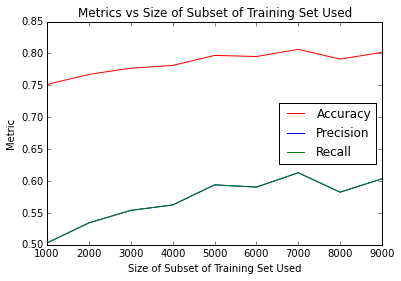

In [2]:
data = pd.read_csv('./performance_test/performance_test_train_size_0000.csv').values
plt.plot(data[:,0], data[:,1], 'r', label='Accuracy')
plt.plot(data[:,0], data[:,2], 'b', label='Precision')
plt.plot(data[:,0], data[:,3], 'g', label='Recall')
plt.xlabel('Size of Subset of Training Set Used')
plt.ylabel('Metric')
plt.title('Metrics vs Size of Subset of Training Set Used')
plt.legend(loc='best')

From this graph, it seems to show that if your size of subset increases, we increase our accuracy, however, it seems to level off quickly and one must decide if the extra computation time is worth the tiny increase in accuracy. As such for future Naive Bayes trials, we used a subset of the training size to be $N=6000$. 

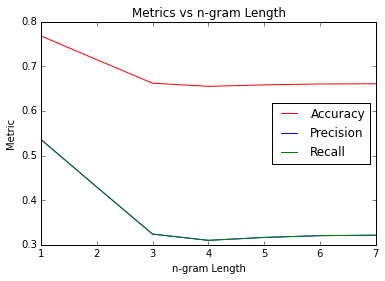

In [3]:
data = pd.read_csv('./performance_test/performance_test_ngram_0000.csv').values
plt.plot(data[:,0], data[:,1], 'r', label='Accuracy')
plt.plot(data[:,0], data[:,2], 'b', label='Precision')
plt.plot(data[:,0], data[:,3], 'g', label='Recall')
plt.xlabel('n-gram Length')
plt.ylabel('Metric')
plt.title('Metrics vs n-gram Length')
plt.legend(loc='best')

Here n-gram length is the size of our n-grams, where 1, 2, 3 are unigram, bigram and trigrams respectively. Here we clearly see that increasing the size of our n-gram without leaving the previous n-grams (as would in the cumulative n-grams) decreases our accuracy.

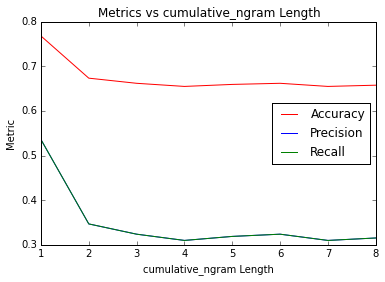

In [4]:
data = pd.read_csv('./performance_test/performance_test_cumulative_ngram_0000.csv').values
plt.plot(data[:,0], data[:,1], 'r', label='Accuracy')
plt.plot(data[:,0], data[:,2], 'b', label='Precision')
plt.plot(data[:,0], data[:,3], 'g', label='Recall')
plt.xlabel('cumulative_ngram Length')
plt.ylabel('Metric')
plt.title('Metrics vs cumulative_ngram Length')
plt.legend(loc='best')

In the cumulative ngrams, having both unigrams and bigrams or unigrams, bigrams and trigrams doesn't increase our accuracy. Thus we can safely use only unigrams in our further trials. 


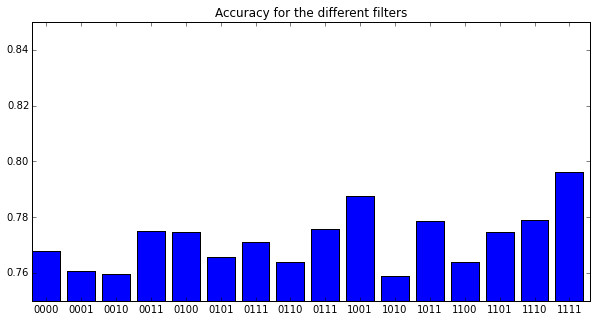

In [28]:
df = pd.read_csv('./performance_test/performance_test_learn_codes_0000.csv')
labels = list(map(str, df['learn_code']))
labels[:9] = ['0000', '0001', '0010', '0011', '0100', '0101', '0111', '0110', '0111']
index = np.arange(len(labels))
accuracy = df['accuracy']
plt.figure(figsize=(10,5))
plt.bar(index, accuracy)
# ax = plt.gca()
plt.xticks(index+0.4, labels)
plt.title('Accuracy for the different filters')
plt.ylim([0.75,0.85])
plt.xlabel('F')
plt.show()


### stuff stuart will write:
false positive/negative charts
mention how first two filters raised accuracy generally, while second two didn't do much, at least for pippin and gimli
validation percents, +/- error if --random or not

# Pros and Cons of Approach and Methodology

### Bag Of Words
In the c


### Ngrams
The get_cumulative_ngrams seemed fairly successful. It takes advantage of the feature dimensionality reduction aspects of bags of words, but with some improvements. A length four ngram for example maintains the ordering of those four words. It is just very localized, but that isn't much of a drawback since there usually isn't a ton of semantic meaning packed into words being twenty words apart.

### Pippin and KNN
Pippin was a lazy learner and it showed. Training Pippin and constructing its ngram id counter was fast, but each prediction task took significantly longer than our better approaches. On a core i5 laptop it classified about ten pieces of text a second. This is partly due to our simple implementation, as finding the nearest neighbours could surely be heuristically accelerated significantly. We merely built a gigantic list of distances to all neighbours and chose the top k neighbours.

### Lowercase and Uppercase
We felt that some information is lost if we blindly set all words to lowercase. Example: "apple" and "Apple". However the way we set most words to lowercase while maintaining case on special words was flawed: if a sentence starts with "Stuart" our naive, non-semantic approach did not recognize that it should remain capitalized.



# Statement of Contributions

### Stuart
boop dee boop

### Zafarali
boop dee boop

### Hannah
boop dee boop

We	hereby	state	that	all	the	work presented	in this	report	is	that	of	the	authors

Statement of Contributions

- Zafarali Ahmed
- Stuart Spence
- Hannah Cohen

## References
*Marina Sokolova and Guy Lapalme*. A systematic analysis of performance measures for classification tasks, Information Processing and Management 2009
[pdf](http://rali.iro.umontreal.ca/rali/sites/default/files/publis/SokolovaLapalme-JIPM09.pdf)